In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer, OneHotEncoderEstimator
from pyspark.sql.functions import corr, udf, regexp_replace, desc, col, when, concat, asc
from pyspark.sql.types import DoubleType, FloatType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [2]:
spark = SparkSession.builder.master("local[4]").appName("spg2").getOrCreate()

In [3]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('data/exercise_03_train.csv')

In [4]:
df.printSchema()

root
 |-- x0: double (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)
 |-- x3: double (nullable = true)
 |-- x4: double (nullable = true)
 |-- x5: double (nullable = true)
 |-- x6: double (nullable = true)
 |-- x7: double (nullable = true)
 |-- x8: double (nullable = true)
 |-- x9: double (nullable = true)
 |-- x10: double (nullable = true)
 |-- x11: double (nullable = true)
 |-- x12: double (nullable = true)
 |-- x13: double (nullable = true)
 |-- x14: double (nullable = true)
 |-- x15: double (nullable = true)
 |-- x16: double (nullable = true)
 |-- x17: double (nullable = true)
 |-- x18: double (nullable = true)
 |-- x19: double (nullable = true)
 |-- x20: double (nullable = true)
 |-- x21: double (nullable = true)
 |-- x22: double (nullable = true)
 |-- x23: double (nullable = true)
 |-- x24: double (nullable = true)
 |-- x25: double (nullable = true)
 |-- x26: double (nullable = true)
 |-- x27: double (nullable = true)
 |-- x28: double (nullabl

In [5]:
# for x in range(0, len(df.columns)):
#     df.select(df.columns[x]).describe().show()

In [6]:
categorical = [typ[0] for typ in df.dtypes if typ[1] == 'string']
df.select(categorical).show(5)

+----------+---------+--------+------+----+----+
|       x34|      x35|     x41|   x45| x68| x93|
+----------+---------+--------+------+----+----+
|     Honda|      wed| $229.47|  0.0%|July|asia|
|     Honda|wednesday|  $213.9| -0.0%| Jun|asia|
|volkswagon|  thurday|$2207.13|-0.02%| Aug|asia|
|volkswagon|  thurday|  $82.09| -0.0%|July|asia|
|      ford|  thurday| $273.61| 0.01%|July|asia|
+----------+---------+--------+------+----+----+
only showing top 5 rows



In [7]:
df = df.withColumn('x41', regexp_replace('x41', '[^\\d.]', '').cast(DoubleType()))
df = df.withColumn('x45', regexp_replace('x45', '[^\\d.]', '').cast(DoubleType()))
df.select(['x41', 'x45']).show(10)

+-------+----+
|    x41| x45|
+-------+----+
| 229.47| 0.0|
|  213.9| 0.0|
|2207.13|0.02|
|  82.09| 0.0|
| 273.61|0.01|
| 439.68| 0.0|
| 152.64|0.02|
| 847.13|0.02|
| 235.98| 0.0|
| 550.02|0.01|
+-------+----+
only showing top 10 rows



In [8]:
df.groupBy('x34').count().show()

+----------+-----+
|       x34|count|
+----------+-----+
|      null|    7|
|volkswagon|12610|
|     Honda| 5176|
|     tesla| 2248|
|       bmw| 7306|
|      ford|  168|
|  mercades|   29|
| chevrolet|   12|
|    nissan|  342|
|    Toyota|10884|
| chrystler| 1218|
+----------+-----+



In [9]:
df.groupBy('x35').count().show()

+---------+-----+
|      x35|count|
+---------+-----+
|      fri|   26|
|     null|    9|
|     thur| 4405|
|   monday|   66|
|      wed|14775|
|wednesday| 5938|
|   friday|  521|
|  tuesday|  882|
|  thurday|13378|
+---------+-----+



In [10]:
fix_days_udf = udf(lambda x: 'wednesday' if x == 'wed' else('thursday' if x == 'thur' or x == 'thurday' else('friday' if x == 'fri' else x)))

df = df.withColumn('x35', fix_days_udf('x35'))

df.groupBy('x35').count().show()

+---------+-----+
|      x35|count|
+---------+-----+
|     null|    9|
| thursday|17783|
|   monday|   66|
|wednesday|20713|
|   friday|  547|
|  tuesday|  882|
+---------+-----+



In [11]:
fix_months_udf = udf(lambda x: 'Jan' if x == 'January' else('Jul' if x == 'July' else('Sep' if x == 'sept.' else('Dec' if x == 'Dev' else x))))

df = df.withColumn('x68', fix_months_udf('x68'))

df.groupBy('x68').count().show()

+----+-----+
| x68|count|
+----+-----+
| Oct|  910|
| Sep| 3514|
| Dec|   21|
|null|   10|
| Aug| 8173|
| May| 4801|
| Jun| 9256|
| Feb|   47|
| Nov|  150|
| Mar|  414|
| Jan|   11|
| Apr| 1640|
| Jul|11053|
+----+-----+



In [12]:
df.printSchema()

root
 |-- x0: double (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)
 |-- x3: double (nullable = true)
 |-- x4: double (nullable = true)
 |-- x5: double (nullable = true)
 |-- x6: double (nullable = true)
 |-- x7: double (nullable = true)
 |-- x8: double (nullable = true)
 |-- x9: double (nullable = true)
 |-- x10: double (nullable = true)
 |-- x11: double (nullable = true)
 |-- x12: double (nullable = true)
 |-- x13: double (nullable = true)
 |-- x14: double (nullable = true)
 |-- x15: double (nullable = true)
 |-- x16: double (nullable = true)
 |-- x17: double (nullable = true)
 |-- x18: double (nullable = true)
 |-- x19: double (nullable = true)
 |-- x20: double (nullable = true)
 |-- x21: double (nullable = true)
 |-- x22: double (nullable = true)
 |-- x23: double (nullable = true)
 |-- x24: double (nullable = true)
 |-- x25: double (nullable = true)
 |-- x26: double (nullable = true)
 |-- x27: double (nullable = true)
 |-- x28: double (nullabl

In [13]:
numeric = [typ[0] for typ in df.dtypes if typ[1] == 'double']

imputer = Imputer(
    inputCols=df.select(numeric).columns, 
    outputCols=df.select(numeric).columns)\
.setStrategy('mean')

df = imputer.fit(df).transform(df)

In [14]:
df.select('x41').describe().show()

+-------+-----------------+
|summary|              x41|
+-------+-----------------+
|  count|            40000|
|   mean|794.7110191528724|
| stddev|602.3889626035261|
|    min|             0.01|
|    max|          4496.46|
+-------+-----------------+



In [15]:
new_cat = [typ[0] for typ in df.dtypes if typ[1] == 'string']

for colu in df.select(new_cat).columns:
    mode = df.groupBy(colu).count().sort(desc('count')).first()[0]
    df = df.fillna({colu : mode})
    categ = df.select(colu).distinct().rdd.flatMap(lambda x:x).collect()
    exprs = [when(col(colu) == cat,1).otherwise(0)\
            .alias(str(cat)) for cat in categ]
    df = df.select(exprs+df.columns)

df.groupBy('x68').count().show()

+---+-----+
|x68|count|
+---+-----+
|Oct|  910|
|Sep| 3514|
|Dec|   21|
|Aug| 8173|
|May| 4801|
|Jun| 9256|
|Feb|   47|
|Nov|  150|
|Mar|  414|
|Jan|   11|
|Apr| 1640|
|Jul|11063|
+---+-----+



In [16]:
df = df.select([typ[0] for typ in df.dtypes if typ[1] != 'string'])
df.printSchema()

root
 |-- america: integer (nullable = false)
 |-- euorpe: integer (nullable = false)
 |-- asia: integer (nullable = false)
 |-- Oct: integer (nullable = false)
 |-- Sep: integer (nullable = false)
 |-- Dec: integer (nullable = false)
 |-- Aug: integer (nullable = false)
 |-- May: integer (nullable = false)
 |-- Jun: integer (nullable = false)
 |-- Feb: integer (nullable = false)
 |-- Nov: integer (nullable = false)
 |-- Mar: integer (nullable = false)
 |-- Jan: integer (nullable = false)
 |-- Apr: integer (nullable = false)
 |-- Jul: integer (nullable = false)
 |-- thursday: integer (nullable = false)
 |-- monday: integer (nullable = false)
 |-- wednesday: integer (nullable = false)
 |-- friday: integer (nullable = false)
 |-- tuesday: integer (nullable = false)
 |-- volkswagon: integer (nullable = false)
 |-- Honda: integer (nullable = false)
 |-- tesla: integer (nullable = false)
 |-- bmw: integer (nullable = false)
 |-- ford: integer (nullable = false)
 |-- mercades: integer (nulla

In [17]:
df.groupBy('america').count().show()

+-------+-----+
|america|count|
+-------+-----+
|      1| 3124|
|      0|36876|
+-------+-----+



In [18]:
scale_assembler = VectorAssembler(inputCols=df.select([typ[0] for typ in df.dtypes if typ[1] == 'double']).columns, outputCol="scaled_features")
df = scale_assembler.transform(df)

dummies_assembler = VectorAssembler(inputCols=df.select([typ[0] for typ in df.dtypes if typ[1] == 'int' and typ[0] != 'y']).columns, outputCol="dummied_features")
df = dummies_assembler.transform(df)

In [62]:
df.select('dummied_features').show()

+--------------------+
|    dummied_features|
+--------------------+
|(30,[2,14,17,21],...|
|(30,[2,8,17,21],[...|
|(30,[2,6,15,20],[...|
|(30,[2,14,15,20],...|
|(30,[2,14,15,24],...|
|(30,[2,14,17,28],...|
|(30,[2,8,15,20],[...|
|(30,[2,14,15,20],...|
|(30,[2,6,15,28],[...|
|(30,[2,14,17,23],...|
|(30,[2,6,15,21],[...|
|(30,[2,8,15,28],[...|
|(30,[2,6,17,21],[...|
|(30,[2,4,17,20],[...|
|(30,[2,14,17,20],...|
|(30,[2,14,17,20],...|
|(30,[2,8,17,29],[...|
|(30,[0,14,17,28],...|
|(30,[2,6,17,20],[...|
|(30,[2,7,17,20],[...|
+--------------------+
only showing top 20 rows



In [64]:
new_vec = VectorAssembler(inputCols=['scaled_features', 'dummied_features'], outputCol="features")
lr_df = new_vec.transform(df)
lr_df.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[83.8123295567722...|
|[-0.4453115534052...|
|[82.9271478130186...|
|[370.736586297153...|
|[33.7752628665715...|
+--------------------+
only showing top 5 rows



In [21]:
# for x in range(0, len(df.columns)):
#     df.select(df.columns[x]).describe().show()

In [65]:
lr_df = lr_df.withColumnRenamed('y', 'label')
train, test = lr_df.randomSplit([0.7, 0.3], seed = 28)

In [68]:
lrModel = LogisticRegression(maxIter=100)

In [69]:
lrModel = lrModel.fit(train)

In [70]:
trainingSummary = lrModel.summary

In [71]:
trainingSummary.areaUnderROC

0.9088851632199597

In [72]:
trainingSummary.accuracy

0.8919179648420752

In [73]:
trainingSummary.pr.show()

+-------------------+------------------+
|             recall|         precision|
+-------------------+------------------+
|                0.0| 0.992831541218638|
|0.04913961326946958| 0.992831541218638|
|0.09827922653893915| 0.992831541218638|
|0.14688664183076106| 0.989247311827957|
|0.19407486251552244|0.9802867383512545|
|0.24037608657087103|0.9713261648745519|
| 0.2854355153450417|0.9611708482676224|
| 0.3297853468156821|0.9518689196108551|
|0.37253858435337944|0.9408602150537635|
| 0.4126308320028384|0.9263241736360016|
|0.44952989178641123|0.9082437275985663|
|0.48447755898527584|0.8898664059954382|
| 0.5185382295547277|0.8730585424133811|
|  0.546744722370055|0.8497380755445272|
| 0.5756608124889125|0.8307731694828469|
| 0.6031577080007096|0.8124253285543608|
| 0.6285258116019159|0.7936827956989247|
| 0.6501685293595885|0.7727176892262281|
| 0.6696824552066702|0.7516925527678215|
| 0.6893737803796346|0.7330692322203358|
+-------------------+------------------+
only showing top

In [74]:
trainingSummary.precisionByLabel

[0.9083762995520244, 0.8018955154877485]

In [75]:
trainingSummary.recallByLabel

[0.9616571965460159, 0.6153982614866064]

In [76]:
trainingSummary.truePositiveRateByLabel

[0.9616571965460159, 0.6153982614866064]

In [77]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()

fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

0.4186092654250552

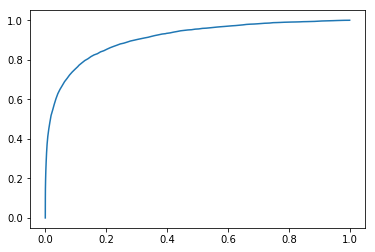

In [78]:
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])

In [89]:
predictions = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)
evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

0.9048041327624263

In [90]:
predictions.select('probability').show()

+--------------------+
|         probability|
+--------------------+
|[0.96880148417795...|
|[0.21706713077703...|
|[0.93286435925222...|
|[0.97563428405921...|
|[0.15366130793932...|
|[0.40326075121273...|
|[0.95025519825920...|
|[0.97382964966322...|
|[0.97199655636082...|
|[0.87236683015762...|
|[0.99605973960127...|
|[0.99895810081040...|
|[0.84205461270852...|
|[0.85914792121867...|
|[0.36572285028482...|
|[0.07394376746963...|
|[0.99224042061524...|
|[0.15382435297175...|
|[0.99611578026910...|
|[0.83395086862024...|
+--------------------+
only showing top 20 rows



In [91]:
firstelement = udf(lambda v:float(v[1]), FloatType())
predictions.select(firstelement('probability').alias('probability'), 'label').sort(desc('probability')).show()

+-----------+-----+
|probability|label|
+-----------+-----+
|   0.999786|    1|
|  0.9997026|    1|
| 0.99969375|    1|
|  0.9993031|    1|
|  0.9992439|    1|
| 0.99917907|    1|
| 0.99917066|    1|
|  0.9990776|    1|
|  0.9990406|    1|
|  0.9988633|    1|
| 0.99868196|    1|
|    0.99835|    1|
|  0.9982475|    1|
| 0.99823093|    1|
| 0.99810827|    1|
| 0.99793714|    1|
| 0.99784964|    1|
|  0.9977921|    1|
| 0.99772567|    1|
|  0.9976351|    1|
+-----------+-----+
only showing top 20 rows

